# House Prices: Advanced Regression Techniques #
### Ridge & Lasso Regression ###

## Packages ##

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats, special

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso

## Training Set Exploration & Engineering ##

### Loading the Training Set ###
Loading training set, dropping the Id column (since it has no purpose in the training), and converting 'MSSubClass' which appears as an integer to an object (since the numbers represent a categorical variable).

In [2]:
train_raw = pd.read_csv("Data/train.csv")
train_raw = train_raw.drop(columns = 'Id')
train_raw = train_raw.astype(dtype = {'MSSubClass': object})

### Analyzing SalePrice Distribution ###

C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


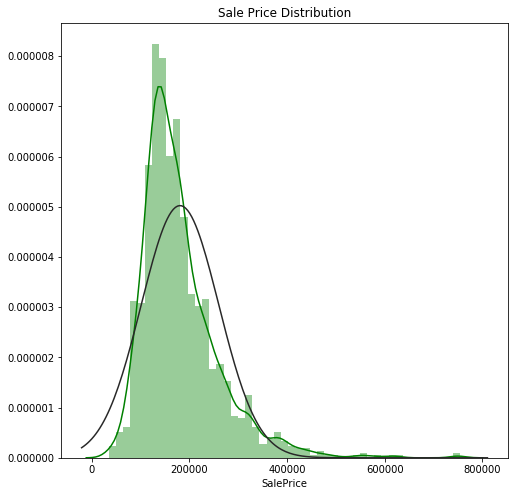

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Sale Price Distribution')

SalePrice_plot = sns.distplot(train_raw['SalePrice'], color = 'green', fit = stats.norm)

### Transforming SalePrice ###
Taking the log of SalePrice in an attempt to try to coerce the data into a normal distribution.

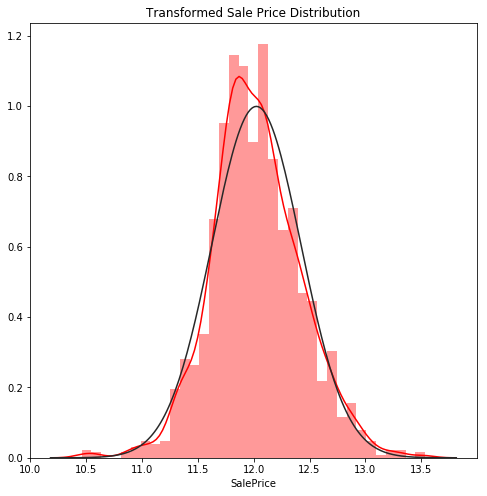

In [4]:
train = train_raw.copy()
train['SalePrice'] = np.log(train['SalePrice'])

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Transformed Sale Price Distribution')

SalePrice_transf_plot = sns.distplot(train['SalePrice'], color = 'red', fit = stats.norm)

### Analyzing Pairwise Correlation Between Variables ###

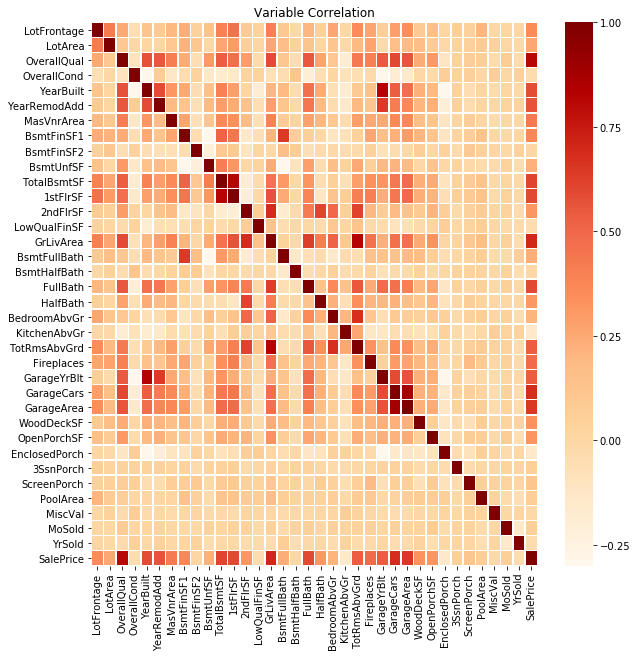

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
corr = train.corr()
corr_heatmap = sns.heatmap(corr, linewidths = .5, vmin = -0.3, vmax = 1, cmap="OrRd")
corr_heatmap.set_title('Variable Correlation')
plt.show()

#### Discovering Highly Correlated Variables ####
It appears that some of the variables may have a high pairwise correlation. This can have negative effects on our model. The most correlated variables are below.

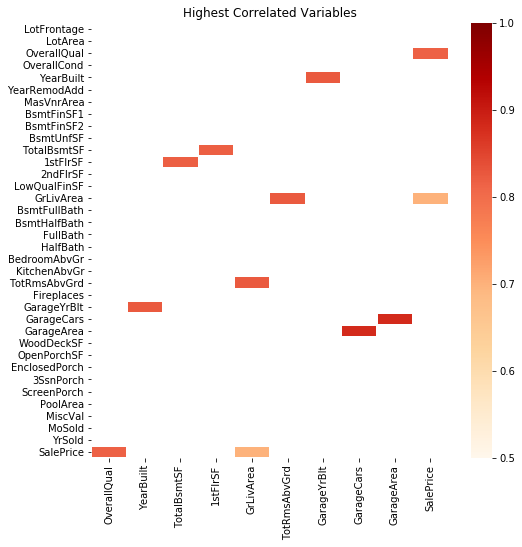

In [6]:
high_corr = corr[(corr > 0.7) & (corr < 1)]
high_corr_drop = high_corr.dropna(axis = 1, how = 'all')

fig, ax = plt.subplots(figsize=(8, 8)) 
high_corr_heatmap = sns.heatmap(high_corr_drop, linewidths = .5, vmin = 0.5, vmax = 1, cmap="OrRd")
high_corr_heatmap.set_title('Highest Correlated Variables')
plt.show()

#### Dropping Highly Correlated Variables ####
By reading the descriptions of the highly correlated variables and looking at each variables' correlation with SalePrice, the variables to drop were chosen.

In [7]:
corr[['YearBuilt', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageCars', 
      'GarageArea']].loc['SalePrice']

train = train.drop(columns = ['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars'])

### Dealing With Impactful Outliers ###
Determining which variables are most correlated with SalePrice and eliminating extreme outliers that could negative affect model.

#### Determining Variables Most Correlated with SalePrice ####
These variables' outliers will have the largest impact on the model.

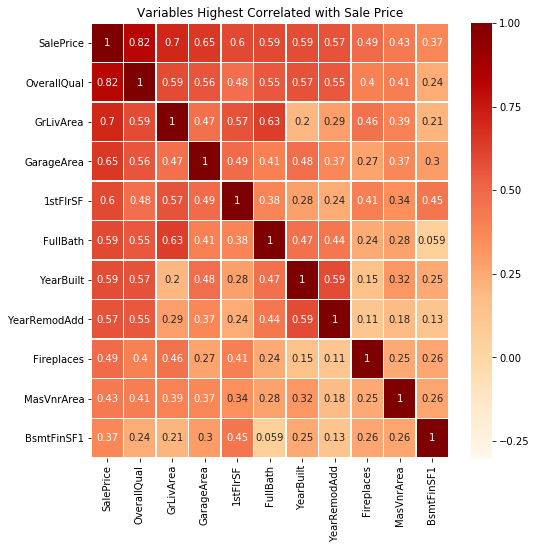

In [8]:
fig, ax = plt.subplots(figsize=(8,8)) 

corr = train.corr()
corr_SalePrice_feats = corr.nlargest(11, 'SalePrice').index
corr_SalePrice_vals = train[corr_SalePrice_feats]
corr_SalePrice_corr = corr_SalePrice_vals.corr()
corr_SalePrice_heatmap = sns.heatmap(corr_SalePrice_corr, annot = True, linewidths = .5, vmin = -0.3, vmax = 1, cmap="OrRd")
corr_SalePrice_heatmap.set_title('Variables Highest Correlated with Sale Price')
plt.show()

#### Plotting Variables with Highest Correlation to SalePrice Against SalePrice ####
These plots will be used to identify outliers.

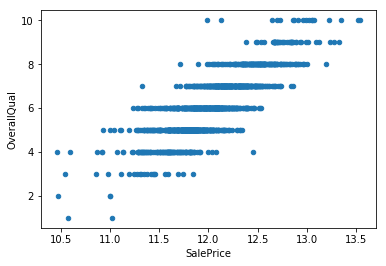

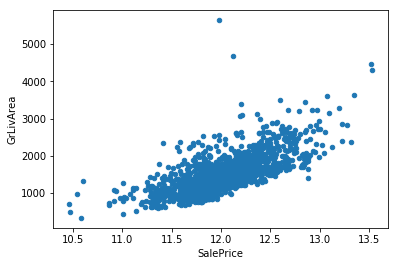

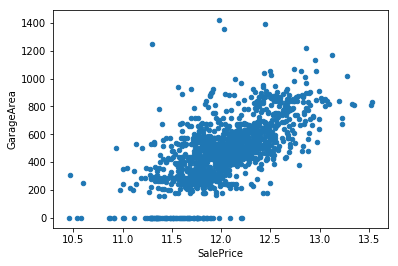

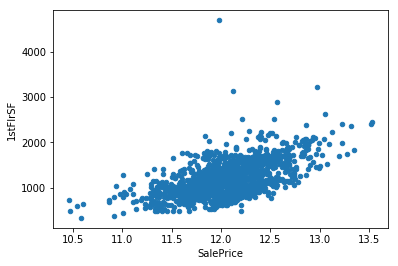

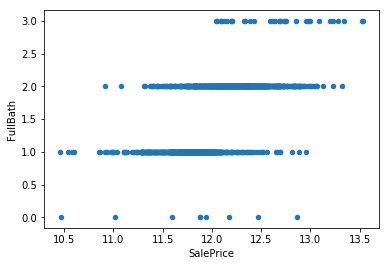

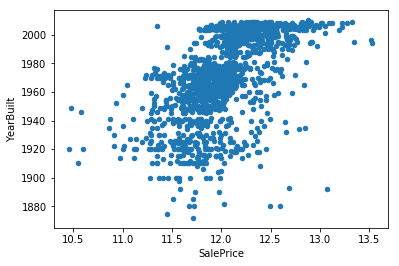

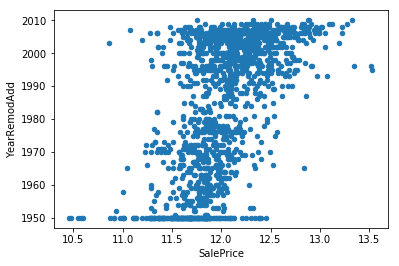

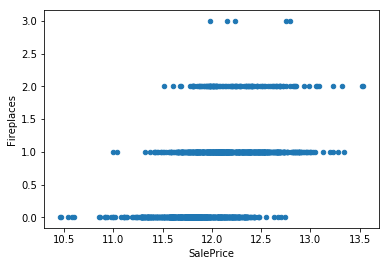

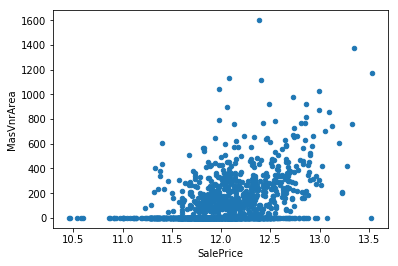

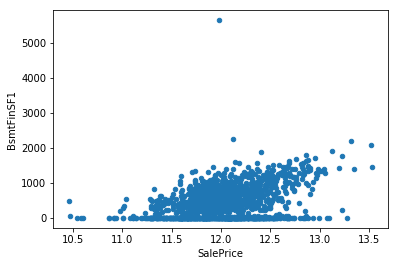

In [9]:
corr_SalePrice_plots = [train.plot.scatter('SalePrice', c) for c in corr_SalePrice_feats.drop('SalePrice')]

#### Eliminating Extreme Outliers (using plots above) ####
Note: Only extreme outliers were removed. Removing all potential outliers could cause overfitting.

In [10]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 8)].index)
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 4.6)].index)
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 8)].index)
train = train.drop(train[(train['1stFlrSF'] > 4000)].index)
train = train.drop(train[(train['BsmtFinSF1'] > 5000)].index)

#### Viewing Improvement in Correlations ####
By eliminating extreme outliers, all individual correlations with SalePrice increased, with the added benefit of most pairwise correlations between other variables decreasing.

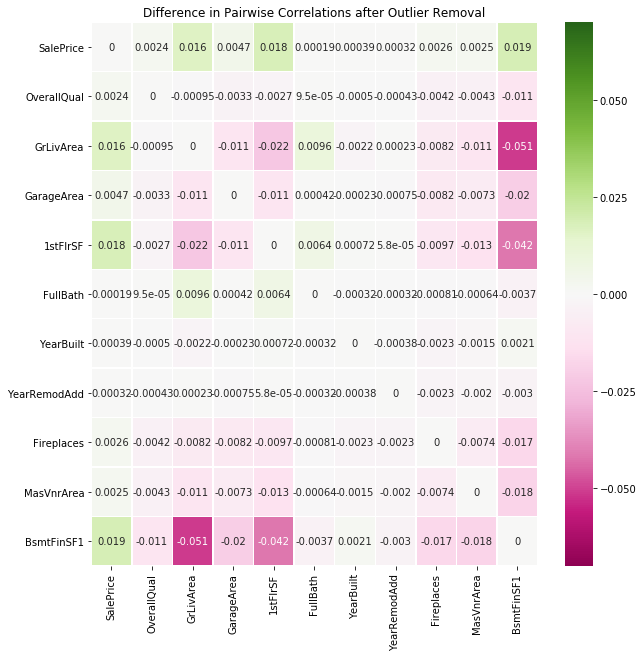

In [11]:
corr2 = train.corr()
corr2_SalePrice_vals = train[corr_SalePrice_feats]
corr2_SalePrice_corr = corr2_SalePrice_vals.corr()

corr_diff = corr2_SalePrice_corr - corr_SalePrice_corr
fig, ax = plt.subplots(figsize = (10,10))
corr_diff_heatmap = sns.heatmap(corr_diff, annot = True, linewidths = .5, vmin = -0.07, vmax = 0.07, cmap="PiYG")
corr_diff_heatmap.set_title('Difference in Pairwise Correlations after Outlier Removal')
plt.show()

### Dealing with Missing Values ###

In [12]:
def check_missing(data_set, percent_missing = 0):
    """Returns the number of missing values of a data frame, based on the total percentage of missing values. Defaults to
    returning only features that have at least one missing value."""
    
    features = list(data_set)
    num_missing = [sum(pd.isna(data_set[features[i]])) for i in range(data_set.shape[1])]
    missing_byfeature = pd.DataFrame(
        {"features": features, 
         "num_missing": num_missing
        })
    
    top_missing = missing_byfeature[missing_byfeature['num_missing'] > data_set.shape[0]*percent_missing/100]
    
    return top_missing

#### Checking for Missing Values & Obtaining Their Type #####

In [13]:
missing = check_missing(train)
missing['dtypes'] = np.array(train.dtypes)[missing.index]

missing

,features,num_missing,dtypes
2,LotFrontage,259,float64
5,Alley,1368,object
24,MasVnrType,8,object
25,MasVnrArea,8,float64
29,BsmtQual,37,object
30,BsmtCond,37,object
31,BsmtExposure,38,object
32,BsmtFinType1,37,object
34,BsmtFinType2,38,object
40,Electrical,1,object


#### Dropping Features with High Missingness ####

Dropping features that are missing more than 70% of its values because they are not complete enough to be useful in building the model.

In [14]:
top_missing = check_missing(train, percent_missing = 70)
train = train.drop(columns = top_missing['features'])

#### Filling in for Missing Numerical Values ####

These numerical values, when NA, do not apply and are technically equal to 0.

In [15]:
train['LotFrontage'] = train['LotFrontage'].fillna(0)
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)

#### Filling in for Missing Categorical Variables ####
When the dummy variables for each of the following categorical features is created, NAs will be replaced with 0s, with
no other necessary adjustments.

* <b>"MasVnrType"</b>: NA indicates no masonry
* <b>"BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"</b>: NA indicates no basement
* <b>"FireplaceQu"</b>: NA indicates to fireplace
* <b>"GarageType", "GarageFinish", "GarageQual", "GarageCond"</b>: NA indicates no garage
* <b>"Electrical"</b>: seemingly random and isolated NA

### Transforming Features ###
Similarly to the transformation of SalePrice, very skewed features of the training set need to be coerced to be more normal.

In [16]:
num_features = train.dtypes[train.dtypes != "object"].index
skew_vals = [(num_features[feat], stats.skew(train[num_features[feat]])) for feat in range(len(num_features))]
skew_vals = pd.DataFrame(skew_vals, columns = ['feature', 'skewness'])
skew_vals = skew_vals[(skew_vals['skewness'] > 0.75) | (skew_vals['skewness'] < -0.75)]

skewed_features = np.array(skew_vals['feature'])
skewed_features

for feat in skewed_features:
    train[feat] = special.boxcox1p(train[feat], 0)
    
train = pd.get_dummies(train)

## Test Set Engineering ##
Loading the test set and completing the same feature engineering as the training set.

In [17]:
test = pd.read_csv("Data/test.csv")
test = test.drop(columns = ['Id'])
test = test.astype(dtype = {'MSSubClass': object})
test = test.drop(columns = ['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars'])
test = test.drop(columns = top_missing['features'])
test['LotFrontage'] = test['LotFrontage'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)

for feat in skewed_features:
    test[feat] = special.boxcox1p(test[feat], 0)

test = pd.get_dummies(test)

### Deleting Unshared Dummies ###
Some dummy variables have so few true values, they do not always show up in both the training and test sets. This causes the sets to have different dimensions, preventing the model from being applied. Because of this, dummy variables that are not found in both data sets are removed.

In [18]:
missing_feats1 = [x for x in list(train) if x not in list(test)]
missing_feats2 = [x for x in list(test) if x not in list(train)]

train_set = train.drop(columns = missing_feats1)
train_set['SalePrice'] = train['SalePrice']
test_set = test.drop(columns = missing_feats2)

## Modeling ##

In [19]:
train_features = train_set.drop(columns = 'SalePrice')
X_train, X_val, y_train, y_val = train_test_split(train_features, train_set[['SalePrice']], test_size = 0.5, random_state = 1)

### Ridge ###

#### Determining Best Alpha Value for Model ####
By plotting the MSEs of different potential alphas and identifying the minimum MSE, the best alpha for the ridge model can be determined.

[0.14340545657183598, 0.1420418806671562, 0.14047435497173222, 0.13845373176637957, 0.13521039032241725, 0.1326330976981098, 0.13041505712499027, 0.1285426080794635, 0.1280997391957302, 0.12878700507790594, 0.13195747841073505]


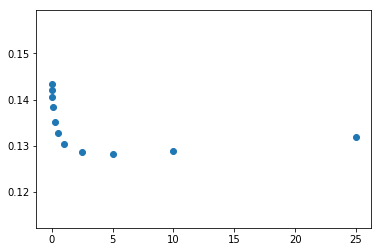

In [20]:
mse = []
ridge_alphas = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2.5, 5, 10, 25]

for alpha in ridge_alphas:
    ridge = Ridge(alpha = alpha, fit_intercept = True)
    ridge.fit(X_train, y_train)
    predict = ridge.predict(X_val)
    mse.append(np.sqrt(mean_squared_error(predict, y_val)))

print(mse)
plt.scatter(ridge_alphas, mse)

#### Using Ridge Model to Obtain Predictions ####
Based on the plot above, the best alpha for the ridge model appears to be 5. This alpha is used in gathering the ridge predictions.

In [21]:
ridge = Ridge(alpha = 5)

ridge.fit(train_features, train_set[['SalePrice']])
ridge_predict = ridge.predict(test_set)
ridge_predicted_vals = np.exp(ridge_predict)

ridge_predictions = pd.DataFrame({'Id': np.array(range(1461, 1461 + len(ridge_predicted_vals)))})
ridge_predictions['SalePrice'] = pd.DataFrame(ridge_predicted_vals)

#### Saving Ridge Predictions as .csv ####

In [22]:
ridge_predictions.to_csv('ridge_predictions.csv', index = False)

### Lasso ###

#### Determining Best Alpha Value for Model ####
This is the same technique used for the ridge model. By plotting the MSEs of different potential alphas and identifying the minimum MSE, the best alpha for the lasso model can be determined.

[0.13309892749519364, 0.12680537494374913, 0.12655619143432748, 0.1432480039720912, 0.1531680723288544, 0.20564590431216598]


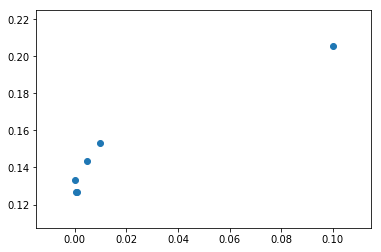

In [23]:
mse = []
lasso_alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]

for alpha in lasso_alphas:
    lasso = Lasso(alpha = alpha, fit_intercept = True)
    lasso.fit(X_train, y_train)
    predict = lasso.predict(X_val)
    mse.append(np.sqrt(mean_squared_error(predict, y_val)))

print(mse)
plt.scatter(lasso_alphas, mse)

#### Using Lasso Model to Obtain Predictions ####
Based on the plot above, the best alpha for the lasso model appears to be 0.0005. This alpha is used in gathering the lasso predictions.

In [24]:
lasso = Lasso(alpha = 0.0005)

lasso.fit(train_features, train[['SalePrice']])
lasso_predict = lasso.predict(test_set)
lasso_predicted_vals = np.exp(lasso_predict)

lasso_predictions = pd.DataFrame({'Id': np.array(range(1461, 1461 + len(lasso_predicted_vals)))})
lasso_predictions['SalePrice'] = pd.DataFrame(lasso_predicted_vals)

#### Saving Lasso Predictions as .csv ####

In [25]:
lasso_predictions.to_csv('lasso_predictions.csv', index = False)

### Averaging Ridge & Lasso ###
Attempting to create a better model by averaging the predictions from the ridge and lasso models. This ends up being the best predictor of the test set.

In [26]:
avg_predictions = pd.DataFrame({'Id': np.array(range(1461, 1461 + len(lasso_predicted_vals)))})
avg_predictions['SalePrice'] = (ridge_predictions['SalePrice'] + lasso_predictions['SalePrice'])/2

#### Saving Averaged Predictions as .csv ####

In [27]:
avg_predictions.to_csv('avg_predictions.csv', index = False)

## Kaggle Competition Score: 0.12051 ##